# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [ ]:
from utils import get_dataset

In [ ]:
dataset = get_dataset("data/processed/*")

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

def display_instances(batch: tf.data.Dataset):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.flatten()

    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    for idx, data in enumerate(batch):
        axes[idx].imshow(data['image'])

        im_width, im_height = data['original_image_spatial_shape']
        for cls, bbox in zip(data['groundtruth_classes'], data['groundtruth_boxes']):
            y1, x1, y2, x2 = bbox.numpy() * np.array([im_height, im_width,im_height, im_width])
            width   = x2 - x1
            height  = y2 - y1
            rect = Rectangle((x1, y1), width, height, facecolor='none', edgecolor=colormap[cls.numpy().item()])
            axes[idx].add_patch(rect)

        # Remove axes for cleaner look
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

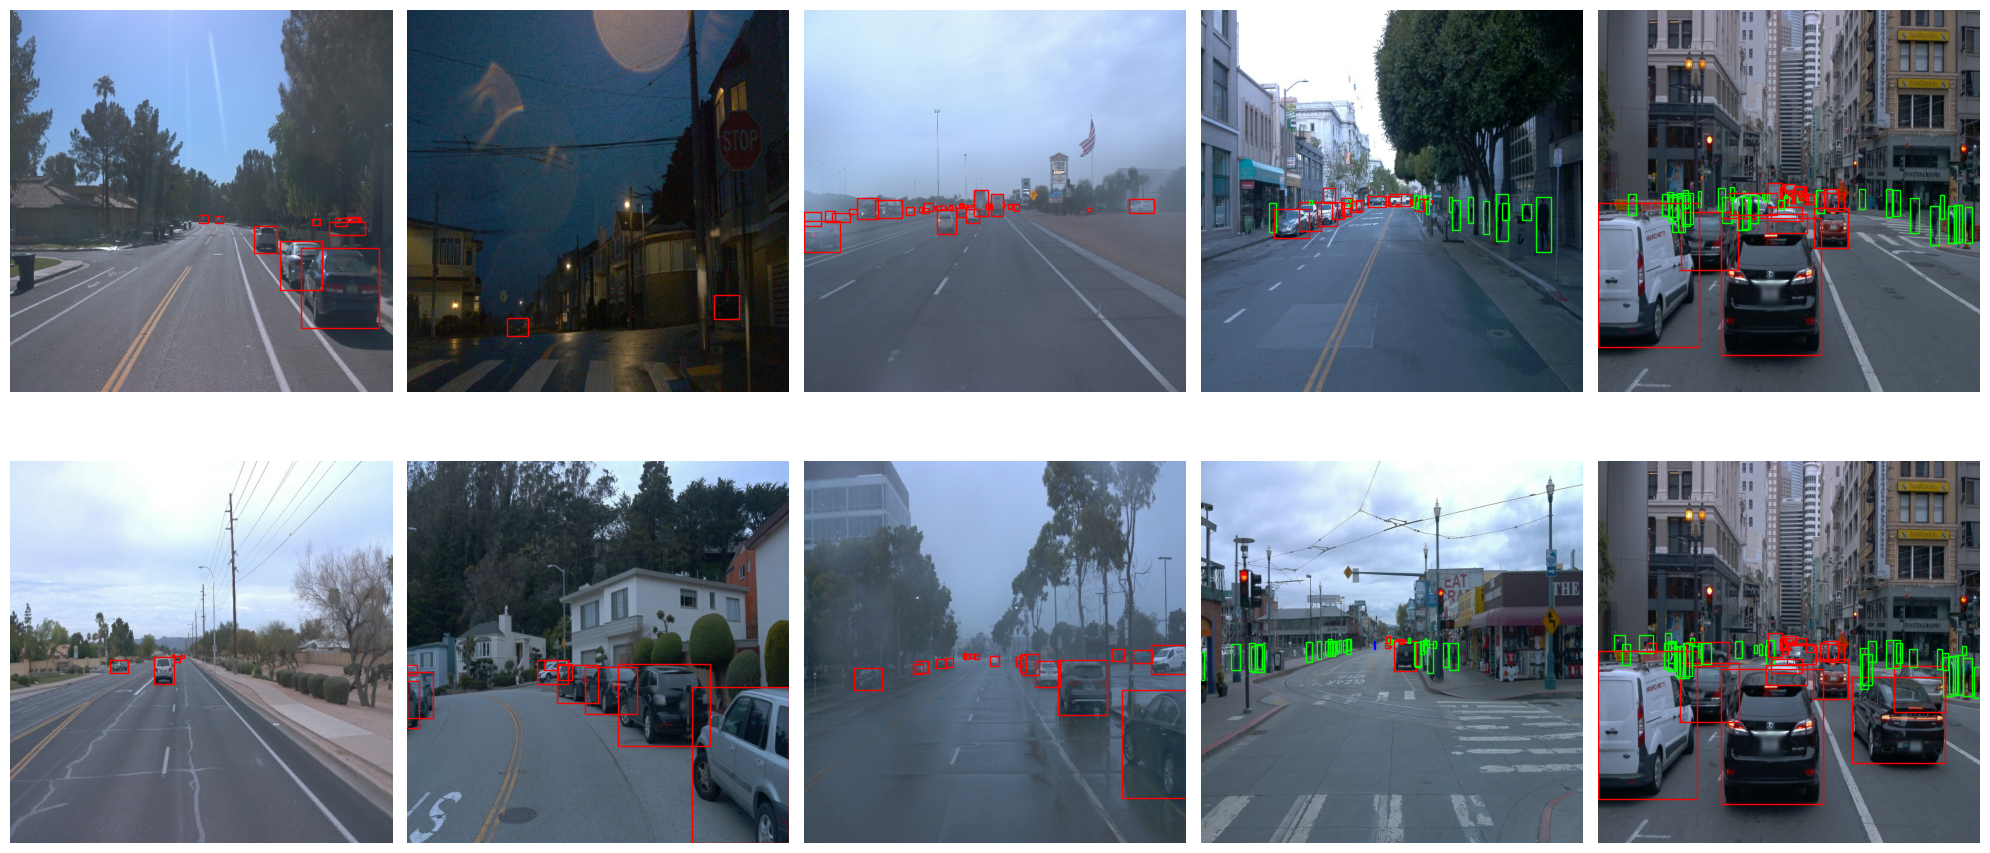

In [4]:
rand_data = dataset.shuffle(buffer_size=1000).take(10)
display_instances(rand_data)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

## Class Distribution Analysis 

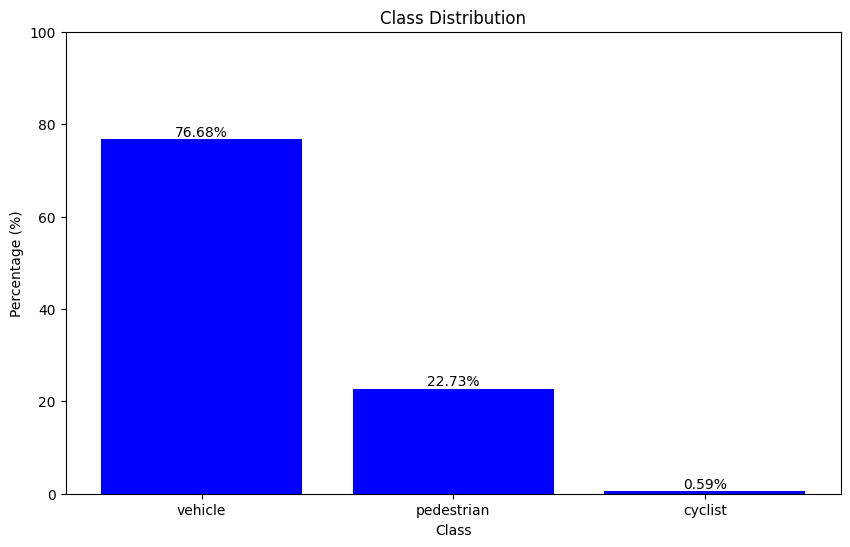

In [9]:
n_class_distributions = {1: 0, 2: 0, 4: 0}
rand_data = dataset.shuffle(buffer_size=1000).take(10000)
for data in rand_data:
    for cls in data['groundtruth_classes']:
        n_class_distributions[cls.numpy().item()] += 1

class_map = {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}

total = sum(n_class_distributions.values())
percentages = {k: (v / total) * 100 for k, v in n_class_distributions.items()}

classes = list(class_map.values())
percentages = list(percentages.values())

# plt.figure(figsize=(10, 6))
# plt.bar(classes, percentages, color='skyblue')

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, percentages, color='blue')

# Adding lines and percentage annotations
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    plt.plot([bar.get_x() + bar.get_width() / 2], [height], 'k-', lw=2)
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{percent:.2f}%', 
            ha='center', va='bottom', color='black', fontsize=10)
    
plt.xlabel('Class')
plt.ylabel('Percentage (%)')
plt.title('Class Distribution')
plt.xticks(classes)
plt.ylim(0, 100) 
plt.show()

**Why we need this analysis?**
-   Imbalanced class distribution can affect the model's performance, especially for underrepresented classes.
    
The above distribution chart for 10000 randomly sampled images, displays the percentage breakdown of three classes: **vehicle**, **pedestrian** and **cyclist**.

1.  Vehicle:
    -   Vehicles make up 76.68% of the data. This shows that the sampled data from original dataset is heavily skewed towards vehicles. Any model trained on this data is likely to perform better on vehicle detectio due to the overwhelming representation.

2.  Pedestrians:
    -   Pedestrians account for 22.73% of the data. While it's significantly less than vehicles, this still provides a moderate amount of pedestrian data for training. However, models might still struggle with pedestrian detection due to the imbalance.

3.  Cyclists:
    -   Cyclists are represented at only 0.59%, a very small portion of the dataset. This makes the cyclist class severely underrepresented, and any model trained on this data may struggle to detect cyclists effectively. This class imbalance could lead to high false negatives for cyclists, making it a potential issue in safety-critical applications.

#### How can we resolve the class imbalances?
*   **Data Augmentation:**  Techniques like data augmentation for minority classes, weighted loss functions, or oversampling the underrepresented classes could help improve model performance on those classes.

## Bounding Box Size Distribution

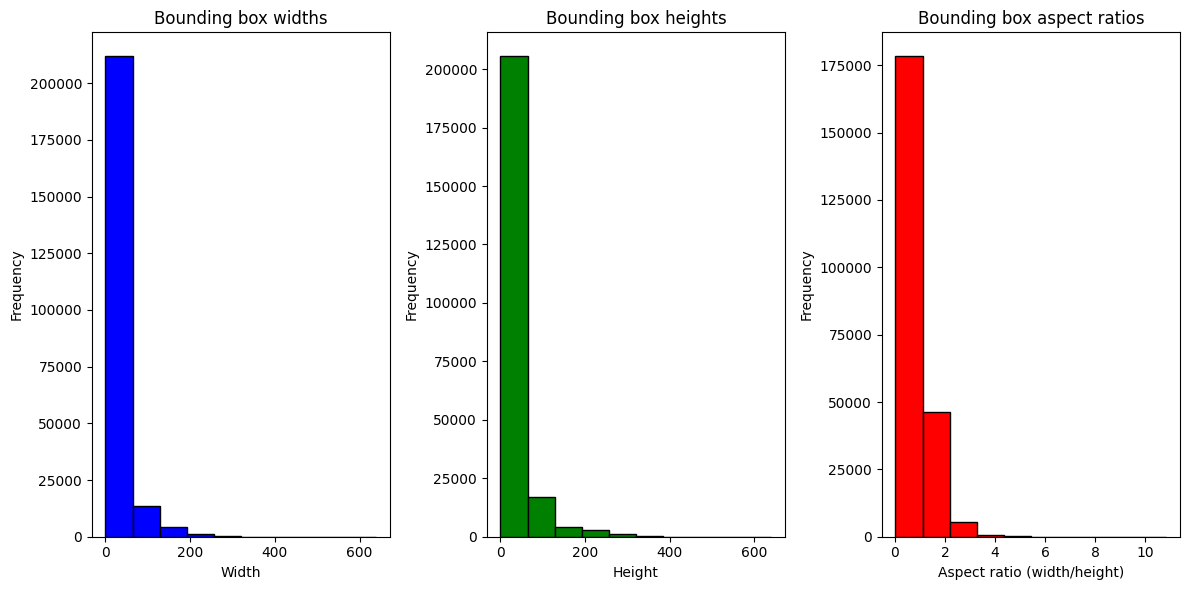

In [19]:
widths = []
heights = []
aspect_ratios = []

for idx, data in enumerate(rand_data):
    im_width, im_height = data['original_image_spatial_shape']
    for cls, bbox in zip(data['groundtruth_classes'], data['groundtruth_boxes']):
        y1, x1, y2, x2 = bbox.numpy() * np.array([im_height, im_width,im_height, im_width])
        width   = x2 - x1
        height  = y2 - y1
        ratio = width/height
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(ratio)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=10, color='blue', edgecolor='black')
plt.title("Bounding box widths")
plt.xlabel("Width")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(heights, bins=10, color='green', edgecolor='black')
plt.title("Bounding box heights")
plt.xlabel("Height")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=10, color='red', edgecolor='black')
plt.title("Bounding box aspect ratios")
plt.xlabel("Aspect ratio (width/height)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Why we need this analysis?**
-   If the bounding boxes vary greatly in size, the model might struggle to detect small objects. Bounding box scale could affect how well the model generalizes.

From the above plot we can see the distribution of the sizes of bounding boxes for different objects.

1.  **Width distribution:**
    -   The histogram shows that most bounding boxes have small widths, with the majority concentrated below 100 pixels.
    -   There is a steep drop-off in the number of bounding boxes as the width increases, with very few bounding boxes having width larger than 200 pixels.

2.  **Heigh distribution:**
    -   Similar to the width ditribution, the heights of the bounding boxes are mostly concentrated in the lower range (below 100 pixels).
    -   The height distribution indicates that the objects are generally small in height as well, with very few objects having bounding boxes taller than 200 pixels.

3. **Bounding box aspect ratio:**
    -   The aspect ratio distribution shows that most bounding boxes have an aspect ratio near 1 (square-like), as indicated by the peak around 1.
    -   There are fewer bounding boxes with larger aspect ratios (greater than 2), meaning there are not many elongated objects in the dataset.
    -   This suggests that most objects are either square-like or slightly elongated but not extreme in one dimension.

## Light and Weather conditions

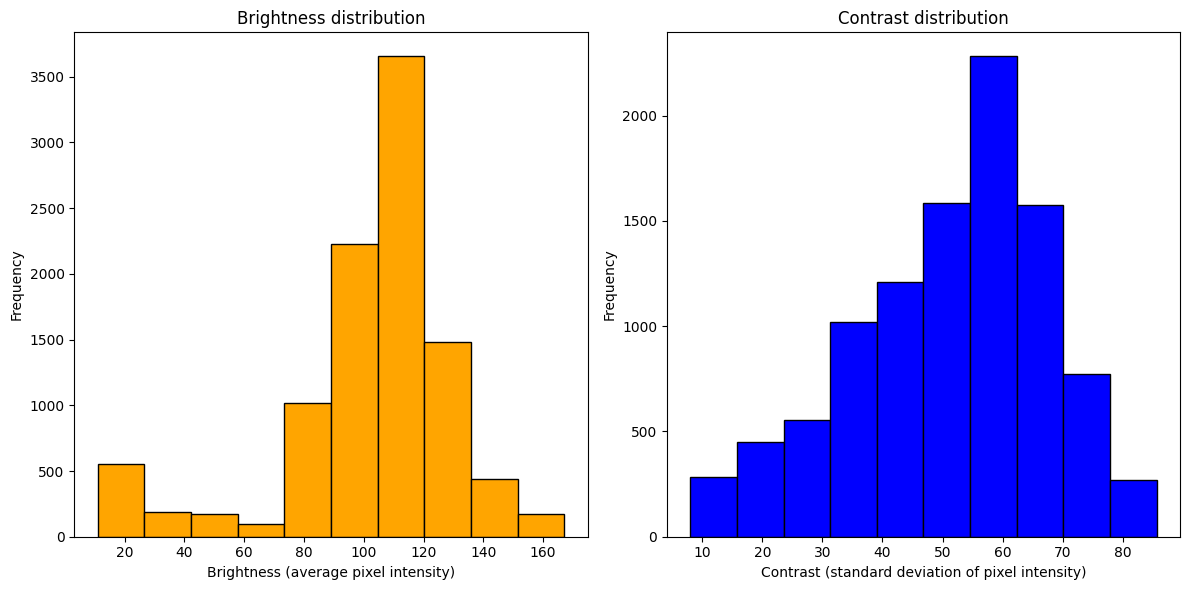

In [18]:
# Lighting and Weather conditions
import cv2
brightness_values = []
contrast_values = []
for idx, data in enumerate(rand_data):
        gray = cv2.cvtColor(data['image'].numpy(), cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        brightness_values.append(brightness)
        contrast_values.append(contrast)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(brightness_values, bins=10, color='orange', edgecolor='black')
plt.title("Brightness distribution")
plt.xlabel("Brightness (average pixel intensity)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(contrast_values, bins=10, color='blue', edgecolor='black')
plt.title("Contrast distribution")
plt.xlabel("Contrast (standard deviation of pixel intensity)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

**Why we need this Analysis?**
-   Object detection performance can be affected by poor lighting or occlusion due to different weather conditions (e.g., rain, sunny, fog, etc.,).

The above plot shows the distribution of brightness and contrast within an image. Analyzing the diversity of environment conditions, like lighting (day/night) or weather (rain, fog, sunny, etc) is very important for outdoor object detection models, so that while preprocessing data for training, we can introduce variabilities in data by data augmentation techniques.

1.  **Brightness distribution:**
    -   The histogram shows the distribution of brightness, measured by the average pixel intensity.
    -   Most images have a brightness value concentrated around 100-120, with a clear peak around 110.
    -   There are very few images with extemely low brightness values (below 40) or high brightness values (above 140).
    -   The lightning conditions seem fairly controlled, which might be beneficial for model performance since lighting variations aren't extreme.

2. **Contrast distribution:**
    -   This histogram shows the distribution of contrast, measured by the standard deviation of pixel intensities.
    -   The peak contrast values are centered around 50-60, indicating that most images have moderate contrast levels.
    -   Very low contrast values (below 20) and very high contrast values (above 70) are rare.
    -   This distribution conveys that there is a good range of tonal differences between lighter and darker areas.